<a href="https://colab.research.google.com/github/athens-igg/dfu-models/blob/main/mobliletnet_alone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()   # select kaggle.json


Saving kaggle (10).json to kaggle (10).json


{'kaggle (10).json': b'{"username":"athenkaggle","key":"af98dc6192c90a45f2237455ea474a73"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp "kaggle (10).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:

!kaggle datasets download -d purushomohan/dfu-wagners-classification

Dataset URL: https://www.kaggle.com/datasets/purushomohan/dfu-wagners-classification
License(s): unknown
  0% 0.00/44.6M [00:00<?, ?B/s]
100% 44.6M/44.6M [00:00<00:00, 551MB/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
!unzip -q dfu-wagners-classification.zip -d /content/drive

In [ ]:
train_data="/content/drive/Dataset/Training"
valid_data="/content/drive/Dataset/Validation"

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100
N_CLASSES = 5   # Wagner 0–4 (adjust if you have normal + ulcer separately)

# ============================
# 1) Data Preprocessing & Augmentation
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_data,  # path to training dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_directory(
    valid_data,  # path to validation dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# ============================
# 2) Define MobileNetV2 Model
# ============================
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model for transfer learning
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
output = Dense(N_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# ============================
# 3) Compile
# ============================
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ============================
# 4) Callbacks
# ============================


checkpoint = ModelCheckpoint(
    "/content/drive/Dataset/best_model.h5",
    monitor="val_loss",   # or "val_loss" if you prefer
    save_best_only=True,
    mode="min"
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, verbose=1),
    checkpoint
]


# ============================
# 5) Train
# ============================
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks
)

# ============================
# 6) Fine-tune (optional)
# ============================
# Unfreeze some top layers
base_model.trainable = True
for layer in base_model.layers[:-30]:  # keep earlier layers frozen
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callbacks
)

Found 965 images belonging to 5 classes.
Found 116 images belonging to 5 classes.
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.5863 - loss: 1.2165

31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 376ms/step - accuracy: 0.5895 - loss: 1.2066 - val_accuracy: 0.6466 - val_loss: 0.9149 - learning_rate: 0.0010
Epoch 2/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.8101 - loss: 0.4741

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 341ms/step - accuracy: 0.8106 - loss: 0.4741 - val_accuracy: 0.7586 - val_loss: 0.6649 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.8535 - loss: 0.4199

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - accuracy: 0.8538 - loss: 0.4189 - val_accuracy: 0.7759 - val_loss: 0.5891 - learning_rate: 0.0010
Epoch 4/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.8797 - loss: 0.3432

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.8797 - loss: 0.3427 - val_accuracy: 0.8190 - val_loss: 0.5217 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.8983 - loss: 0.2902

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.8978 - loss: 0.2908 - val_accuracy: 0.8103 - val_loss: 0.5091 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.8912 - loss: 0.3012

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 341ms/step - accuracy: 0.8913 - loss: 0.3009 - val_accuracy: 0.8707 - val_loss: 0.4097 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.9279 - loss: 0.2619 - val_accuracy: 0.8793 - val_loss: 0.4113 - learning_rate: 0.0010
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.9230 - loss: 0.2485 - val_accuracy: 0.8103 - val_loss: 0.4622 - learning_rate: 0.0010
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - accuracy: 0.9137 - loss: 0.2217 - val_accuracy: 0.8276 - val_loss: 0.4586 - learning_rate: 0.0010
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9190 - loss: 0.2502

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.9187 - loss: 0.2503 - val_accuracy: 0.8879 - val_loss: 0.3318 - learning_rate: 0.0010
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.9185 - loss: 0.2341 - val_accuracy: 0.8707 - val_loss: 0.3593 - learning_rate: 0.0010
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9287 - loss: 0.2269

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - accuracy: 0.9288 - loss: 0.2265 - val_accuracy: 0.9138 - val_loss: 0.2954 - learning_rate: 0.0010
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step - accuracy: 0.9011 - loss: 0.2520 - val_accuracy: 0.8793 - val_loss: 0.3132 - learning_rate: 0.0010
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9331 - loss: 0.1899

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.9326 - loss: 0.1908 - val_accuracy: 0.9138 - val_loss: 0.2702 - learning_rate: 0.0010
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9343 - loss: 0.2030

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 340ms/step - accuracy: 0.9342 - loss: 0.2030 - val_accuracy: 0.9224 - val_loss: 0.2504 - learning_rate: 0.0010
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - accuracy: 0.9272 - loss: 0.2061 - val_accuracy: 0.9052 - val_loss: 0.2678 - learning_rate: 0.0010
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.9414 - loss: 0.1717 - val_accuracy: 0.9138 - val_loss: 0.2632 - learning_rate: 0.0010
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9332 - loss: 0.1757

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 341ms/step - accuracy: 0.9332 - loss: 0.1760 - val_accuracy: 0.9397 - val_loss: 0.2466 - learning_rate: 0.0010
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.9379 - loss: 0.1842 - val_accuracy: 0.9138 - val_loss: 0.2533 - learning_rate: 0.0010
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9245 - loss: 0.2059

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 340ms/step - accuracy: 0.9248 - loss: 0.2052 - val_accuracy: 0.9224 - val_loss: 0.2396 - learning_rate: 0.0010
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9448 - loss: 0.1746

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.9446 - loss: 0.1747 - val_accuracy: 0.9310 - val_loss: 0.2284 - learning_rate: 0.0010
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9265 - loss: 0.1877

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.9268 - loss: 0.1876 - val_accuracy: 0.9397 - val_loss: 0.2023 - learning_rate: 0.0010
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - accuracy: 0.9471 - loss: 0.1525 - val_accuracy: 0.9310 - val_loss: 0.2179 - learning_rate: 0.0010
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9395 - loss: 0.1623

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 345ms/step - accuracy: 0.9394 - loss: 0.1628 - val_accuracy: 0.9397 - val_loss: 0.1877 - learning_rate: 0.0010
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.9447 - loss: 0.1505 - val_accuracy: 0.9397 - val_loss: 0.1924 - learning_rate: 0.0010
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - accuracy: 0.9393 - loss: 0.1737 - val_accuracy: 0.9224 - val_loss: 0.2042 - learning_rate: 0.0010
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/step - accuracy: 0.9634 - loss: 0.1232 - val_accuracy: 0.9310 - val_loss: 0.1966 - learning_rate: 0.0010
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - accuracy: 0.9567 - loss: 0.1556 - val_accuracy: 0.9138 - val_loss: 0.1959 - learning_rate: 0.0010
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9496 - loss: 0.1662

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.9495 - loss: 0.1655 - val_accuracy: 0.9397 - val_loss: 0.1775 - learning_rate: 0.0010
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.9599 - loss: 0.1386 - val_accuracy: 0.9397 - val_loss: 0.1796 - learning_rate: 0.0010
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.9542 - loss: 0.1383 - val_accuracy: 0.9397 - val_loss: 0.1790 - learning_rate: 0.0010
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9411 - loss: 0.1513

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 333ms/step - accuracy: 0.9411 - loss: 0.1515 - val_accuracy: 0.9483 - val_loss: 0.1617 - learning_rate: 0.0010
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9410 - loss: 0.1504

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - accuracy: 0.9410 - loss: 0.1507 - val_accuracy: 0.9483 - val_loss: 0.1487 - learning_rate: 0.0010
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - accuracy: 0.9504 - loss: 0.1483 - val_accuracy: 0.9569 - val_loss: 0.1504 - learning_rate: 0.0010
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - accuracy: 0.9506 - loss: 0.1355 - val_accuracy: 0.9483 - val_loss: 0.1646 - learning_rate: 0.0010
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9513 - loss: 0.1247

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 340ms/step - accuracy: 0.9512 - loss: 0.1250 - val_accuracy: 0.9569 - val_loss: 0.1482 - learning_rate: 0.0010
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.9473 - loss: 0.1450

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 345ms/step - accuracy: 0.9475 - loss: 0.1446 - val_accuracy: 0.9569 - val_loss: 0.1410 - learning_rate: 0.0010
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 324ms/step - accuracy: 0.9310 - loss: 0.1422 - val_accuracy: 0.9483 - val_loss: 0.1652 - learning_rate: 0.0010
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9440 - loss: 0.1347

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 340ms/step - accuracy: 0.9441 - loss: 0.1348 - val_accuracy: 0.9569 - val_loss: 0.1352 - learning_rate: 0.0010
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.9482 - loss: 0.1450 - val_accuracy: 0.9569 - val_loss: 0.1387 - learning_rate: 0.0010
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9471 - loss: 0.1405

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - accuracy: 0.9471 - loss: 0.1403 - val_accuracy: 0.9655 - val_loss: 0.1346 - learning_rate: 0.0010
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9484 - loss: 0.1349

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step - accuracy: 0.9483 - loss: 0.1354 - val_accuracy: 0.9741 - val_loss: 0.1298 - learning_rate: 0.0010
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - accuracy: 0.9530 - loss: 0.1264 - val_accuracy: 0.9569 - val_loss: 0.1418 - learning_rate: 0.0010
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9612 - loss: 0.1067

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 346ms/step - accuracy: 0.9610 - loss: 0.1073 - val_accuracy: 0.9741 - val_loss: 0.1280 - learning_rate: 0.0010
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 336ms/step - accuracy: 0.9469 - loss: 0.1332 - val_accuracy: 0.9828 - val_loss: 0.1303 - learning_rate: 0.0010
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/step - accuracy: 0.9470 - loss: 0.1401 - val_accuracy: 0.9397 - val_loss: 0.1531 - learning_rate: 0.0010
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9512 - loss: 0.1278

31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 335ms/step - accuracy: 0.9510 - loss: 0.1285 - val_accuracy: 0.9828 - val_loss: 0.1128 - learning_rate: 0.0010
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.9563 - loss: 0.1273 - val_accuracy: 0.9741 - val_loss: 0.1382 - learning_rate: 0.0010
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.9566 - loss: 0.1224 - val_accuracy: 0.9569 - val_loss: 0.1435 - learning_rate: 0.0010
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 329ms/step - accuracy: 0.9506 - loss: 0.1346 - val_accuracy: 0.9741 - val_loss: 0.1178 - learning_rate: 0.0010
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 328ms/step - accuracy: 0.9390 - loss: 0.1467 - val_accuracy: 0.9483 - val_loss: 0.1234 - learning_rate: 0.0010
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9609 - loss: 0.1336
Epoch 52: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - accuracy: 0.9610 - loss: 0.1

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.9780 - loss: 0.0483 - val_accuracy: 0.9310 - val_loss: 0.1101 - learning_rate: 2.0000e-05
Epoch 40/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9694 - loss: 0.0669

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 359ms/step - accuracy: 0.9695 - loss: 0.0665 - val_accuracy: 0.9397 - val_loss: 0.1013 - learning_rate: 2.0000e-05
Epoch 41/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.9746 - loss: 0.0549

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 365ms/step - accuracy: 0.9746 - loss: 0.0549 - val_accuracy: 0.9483 - val_loss: 0.0936 - learning_rate: 2.0000e-05
Epoch 42/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.9754 - loss: 0.0451 - val_accuracy: 0.9483 - val_loss: 0.0944 - learning_rate: 2.0000e-05
Epoch 43/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.9712 - loss: 0.0630 - val_accuracy: 0.9569 - val_loss: 0.0994 - learning_rate: 2.0000e-05
Epoch 44/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9771 - loss: 0.0504

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.9772 - loss: 0.0502 - val_accuracy: 0.9569 - val_loss: 0.0927 - learning_rate: 2.0000e-05
Epoch 45/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.9794 - loss: 0.0409

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.9792 - loss: 0.0413 - val_accuracy: 0.9483 - val_loss: 0.0857 - learning_rate: 2.0000e-05
Epoch 46/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step - accuracy: 0.9825 - loss: 0.0438 - val_accuracy: 0.9483 - val_loss: 0.0917 - learning_rate: 2.0000e-05
Epoch 47/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 363ms/step - accuracy: 0.9671 - loss: 0.0570 - val_accuracy: 0.9483 - val_loss: 0.0924 - learning_rate: 2.0000e-05
Epoch 48/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 361ms/step - accuracy: 0.9680 - loss: 0.0567 - val_accuracy: 0.9569 - val_loss: 0.0902 - learning_rate: 2.0000e-05
Epoch 49/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 347ms/step - accuracy: 0.9759 - loss: 0.0460 - val_accuracy: 0.9569 - val_loss: 0.0879 - learning_rate: 2.0000e-05
Epoch 50/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.9740 - loss: 0.0535

31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.9739 - loss: 0.0535 - val_accuracy: 0.9483 - val_loss: 0.0825 - learning_rate: 2.0000e-05


In [ ]:
from tensorflow.keras.models import load_model

# Load the best model saved by ModelCheckpoint
best_model = load_model("/content/drive/Dataset/best_model.h5")

# Evaluate on validation data
val_loss, val_acc = best_model.evaluate(val_gen)
print(f"Best Validation Accuracy: {val_acc*100:.2f}%")
print(f"Best Validation Loss: {val_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9543 - loss: 0.0779
Best Validation Accuracy: 94.83%
Best Validation Loss: 0.0825


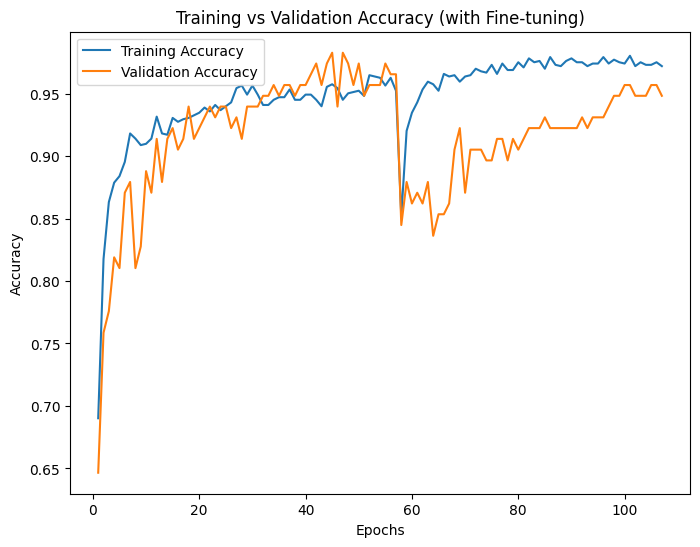

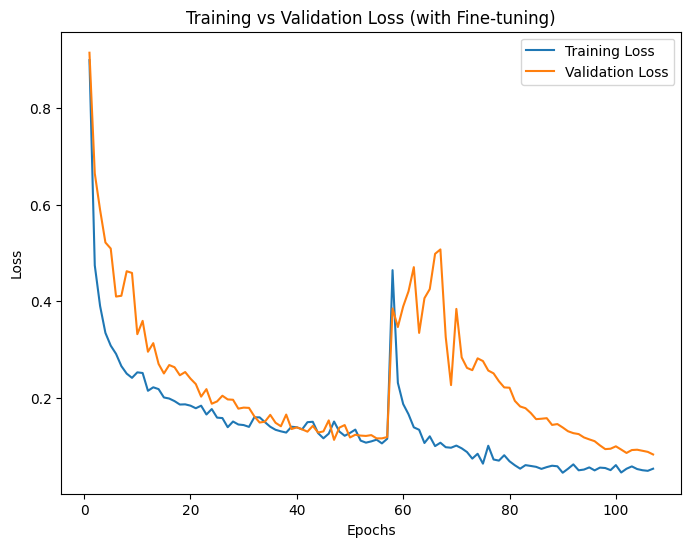

In [ ]:
import matplotlib.pyplot as plt

# Merge history and fine-tuning history
acc = history.history['accuracy'] + history_ft.history['accuracy']
val_acc = history.history['val_accuracy'] + history_ft.history['val_accuracy']
loss = history.history['loss'] + history_ft.history['loss']
val_loss = history.history['val_loss'] + history_ft.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(8,6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (with Fine-tuning)')
plt.legend()
plt.show()

# Plot loss
plt.figure(figsize=(8,6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (with Fine-tuning)')
plt.legend()
plt.show()


In [ ]:
model.save('/content/drive/Dataset/best_model.h5')


Saving Screenshot 2025-09-21 233831.png to Screenshot 2025-09-21 233831.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


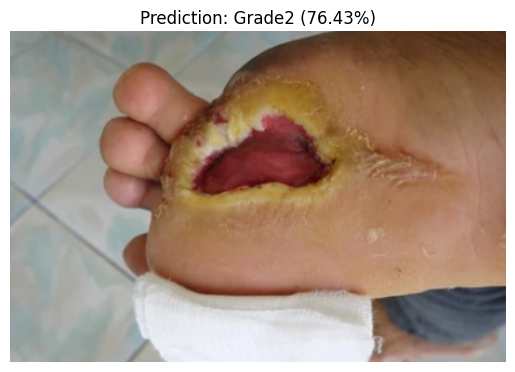

In [ ]:
!pip install opencv-python-headless
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Upload image
uploaded = files.upload()
class_names = ["Grade 0", "Grade1", "Grade2", "Grade3", "Normal" ]
filename = list(uploaded.keys())[0]

# Load and preprocess image
IMG_SIZE = (224, 224)
img = cv2.imread(filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_rgb, IMG_SIZE)

# Normalize same as training (rescale 1/255)
img_array = img_resized.astype("float32") / 255.0
img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

# Predict
pred = best_model.predict(img_array)
class_id = np.argmax(pred)
confidence = np.max(pred)

# Show result
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Prediction: {class_names[class_id]} ({confidence*100:.2f}%)")
plt.show()

In [ ]:
model.save('best_model.h5')

from google.colab import files
files.download('best_model.h5')

NameError: name 'model' is not defined